# Introduction

The purpose of this notebook is to create a **fast ice** dataset from a simulated/modelled sea ice experiment using [CICE](https://cice-consortium-cice.readthedocs.io/en/cice6.4.1/) (or [CICE github](https://github.com/CICE-Consortium/CICE)).

## Notes
1. Some basic knowledge of Python3+ and Jupyter is required
   
3. This notebook has only been tested on the HPC **gadi**. The reason for this is mainly due to the large file sizes of the modelled sea ice experiment that are output as daily-averaged history. *and* to efficiently run CICE it is best practice to do this using hundreds of CPUs at a time. Hence this notebook has been only tested on the HPC gadi. However, that being said, there is no real reason that this notebook and underlying object-oriented Python modules cannot be run on a smaller HPC or even laptop.

4. There are underlying python modules that I have written and these provide the methods/functions that perform the work of this notebook.

5. The Python modules and this notebook were developed ``xp65`` which has a well maintained *conda* environment. This notebook is intended to be run with this basic ``ARE`` configuration ``PBS -l storage=gdata/gv90+gdata/hh5+gdata/ik11+gdata/jk72`` and then ``module use /g/data/hh5/public/modules; module load conda/analysis3-25.05``. If you have a (local) virtual environment that is equivalent to the libraries of ``conda/analysis3-25.05`` then this notebook should work for you.

+ **NOTE 3**: If you have a local directory of CICE generated results then you should edit ``../src/JSONs/afim_cice_analysis.json`` and the dictionary therein named ``D_dict``. The module/class ``SeaIceProcessor`` assumes you have simulations stored there-under with the relative-path naming convention of daily-averaged CICE model results stored as: ``[SIM_NAME]/history/daily/iceh.YYYY-MM-DD.nc``. ``SIM_NAME``

+ **NOTE 4**: If you do not have CICE generated **and** have access to __gadi__ projects: ``gv90``, ``jk72``, and ``xp65``; then this notebook should work for you in a *test* or *evaluation* mode.

# Clone the AFIM Repository

1. You do not need to edit anything here unless you want. This will clone AFIM to your local home directory.

In [3]:
import os, importlib
from pathlib import Path
# Set the directory where to clone;
# change D_repo to the directory of your choosing
AFIM_repo  = "https://github.com/dpath2o/AFIM.git"
D_repo_loc = Path.home() / "AFIM"
# use the os.system call to clone the repo if it does not already exist
if not D_repo_loc.exists():
    os.system(f"git clone {AFIM_repo} {D_repo_loc}")
else:
    print(f"AFIM repo previously cloned at: {D_repo_loc}")

AFIM repo previously cloned at: /home/581/da1339/AFIM


## Syncing any possible changes of locally cloned ``AFIM`` repo with current kernel instance
If changes have been made to the cloned local copies of any of the AFIM classes: ``sea_ice_processor``, ``sea_ice_plotter`` or ``grounded_iceberg_processor``; **while** the kernel is running, then the following cell needs to be run in order for the kernel to *aware* of those changes. Else this cell can remain collapsed.

In [68]:
import sea_ice_processor
import sea_ice_plotter
import grounded_iceberg_processor
# Reload them if they were edited
importlib.reload(sea_ice_processor)
importlib.reload(sea_ice_plotter)
importlib.reload(grounded_iceberg_processor)
# Then (re)import the classes from the reloaded modules
from sea_ice_processor          import SeaIceProcessor
from sea_ice_plotter            import SeaIcePlotter
from grounded_iceberg_processor import GroundedIcebergProcessor

# Define Parameters
+ Next to each parameter below is a brief description of what the parameters *controls* within any/all of the ``AFIM`` modules.
+ If running this notebook in evaluation mode then this should not need any editing
+ Please do not **enable** ``overwrite_zarr`` **unless** you are working with your own version of CICE simulation results.

For a complete list of simulation names that are currently *valid*, see [afim_cice_analysis.json dictionary ``sim_dict``](https://github.com/dpath2o/AFIM/blob/bcad2e0c949f221f79e4b9dae1742452fd937d13/src/JSONs/afim_cice_analysis.json#L144). ``sim_dict`` keys represent the simulation names. Please feel free to try other simulation name out to test. 

```python
# ARE project you are working
project_name    = "gv90"      
# gadi user name
user_name       = "da1339" 
# unique name of CICE generated results; for a complete list see
sim_name        = "gi-mid"
# sea ice speed threshold; values below which will be considered fast ice -- values should be reasonable for fast ice :-) 
ispd_thresh     = 5e-4 
# sea ice speed re-gridding scheme; requires lengthy explanation; see method documenation 
ispd_types      = ["ispd_BT"]
# "FI" = fast ice; "PI" = pack ice; suffix should be the same as ispd_types (i.e. "_BT" and "_BT", or "_Ta" and "_Ta", etc.) 
ice_types       = ["FI_BT"]
# date to start the processing/analysis; can be any valid date within the simulation period
start_date      = "1993-01-01"
# date to cease the processing/analysis; can be any valid date within the simulation period that is more recent than the start date
end_date        = "1993-12-31"
# enable/disable thresholding sea ice speed of daily-averaged CICE results
daily           = True
# enable/disable thresholding sea ice speed of N-day rolling-average of CICE results
rolling         = True
# days to compute the rolling average
roll_period     = 15
# whether or not to overwrite existing zarr files that may exist for the sea ice speed threshold and ispd_type
# ONLY enable if you are confident you want to change your existing results!! 
overwrite_zarr  = False
# whether or not to overwrite existing graphic files that have been generated by this workflow
overwrite_png   = False
# delete the original CICE netcdf and just keep the zarr; very handy in reducing disk storage
delete_original = False
# add your local edited version of ../src/JSONs/afim_cice_analysis.json; else load default
json_config     = None         
```

In [12]:
project_name    = "gv90"       
user_name       = "da1339"     
sim_name        = "gi-nil"     
ispd_thresh     = 5e-4         
ispd_types      = ["ispd_BT"]  
ice_types       = ["FI_BT"]    
start_date      = "1993-01-01" 
end_date        = "1993-12-31" 
daily           = True         
rolling         = True         
roll_period     = 15           
overwrite_zarr  = False                                      
overwrite_png   = False        
delete_original = False        
json_config     = None         
log_file        = f"/g/data/{project_name}/{user_name}/logs/process_fast_ice/{sim_name}/{start_date}_{end_date}_{ispd_thresh}.log"

# Intialise ``SeaIceProcessor`` class
+ This loads the JSON configuration file, starts a log file, as well as loads a grid and landmask file from ``GroundedIcebergProcessor`` class
+ See [SeaIceProcessor](https://github.com/dpath2o/AFIM/blob/bcad2e0c949f221f79e4b9dae1742452fd937d13/src/sea_ice_processor.py#L14) for class-level documentation

In [69]:
import sys
sys.path.insert(0, str(D_repo_loc / "src" / "AFIM" / "src"))
from sea_ice_processor import SeaIceProcessor
# Create processor instance
SI_proc = SeaIceProcessor(P_json              = json_config,
                          P_log               = log_file,
                          dt0_str             = start_date,
                          dtN_str             = end_date,
                          sim_name            = sim_name,
                          ice_speed_threshold = ispd_thresh)

touch: cannot touch '/g/data/gv90/da1339/logs/process_fast_ice/gi-nil/1993-01-01_1993-12-31_0.0005.log': No such file or directory
2025-06-07 22:39:21,207 - INFO - hemisphere initialised: south
INFO:gi-nil:hemisphere initialised: south
2025-06-07 22:39:21,253 - INFO - Ice speed threshold                        : 5.0e-04 m/s → 43.2 m/day
INFO:gi-nil:Ice speed threshold                        : 5.0e-04 m/s → 43.2 m/day
2025-06-07 22:39:21,255 - INFO - Median grid cell length below -60°: 10365.7 m
INFO:gi-nil:Median grid cell length below -60°: 10365.7 m
2025-06-07 22:39:21,256 - INFO - → Displacement                             = 0.42% of grid cell per day
INFO:gi-nil:→ Displacement                             = 0.42% of grid cell per day
2025-06-07 22:39:21,258 - INFO - → Days to fully traverse one grid cell     : 239.95 days
INFO:gi-nil:→ Days to fully traverse one grid cell     : 239.95 days


# Convert daily-averaged CICE NetCDF files to monthly-concatenated daily-averaged zarr files 
+ Hugely beneficial for working with thousands of large NetCDF files
+ I have found this reduces disk-usage of daily-averaged CICE NetCDF (``iceh.*.nc`` history) files by **70%**
+ This only needs to be run once after new simulation results are obtained
+ See [daily_iceh_to_monthly_zarr](https://github.com/dpath2o/AFIM/blob/bcad2e0c949f221f79e4b9dae1742452fd937d13/src/sea_ice_processor.py#L257) for rationale

In [14]:
SI_proc.daily_iceh_to_monthly_zarr(overwrite=overwrite_zarr, delete_original=delete_original)

2025-06-07 19:37:57,283 - INFO - Skipping existing /g/data/gv90/da1339/afim_output/gi-nil/zarr/iceh_1993-01.zarr
INFO:gi-nil:Skipping existing /g/data/gv90/da1339/afim_output/gi-nil/zarr/iceh_1993-01.zarr
2025-06-07 19:37:57,285 - INFO - Loading NetCDF files for 1993-01 via xarray mfdataset ...
INFO:gi-nil:Loading NetCDF files for 1993-01 via xarray mfdataset ...
2025-06-07 19:38:02,847 - INFO - ⏳ Writing 1993-01 to /g/data/gv90/da1339/afim_output/gi-nil/zarr/iceh_1993-01.zarr
INFO:gi-nil:⏳ Writing 1993-01 to /g/data/gv90/da1339/afim_output/gi-nil/zarr/iceh_1993-01.zarr
2025-06-07 19:38:12,161 - INFO - 📏 Disk-usage (size) of directory /g/data/gv90/da1339/afim_output/gi-nil/zarr/iceh_1993-01.zarr: 0.81 GB
INFO:gi-nil:📏 Disk-usage (size) of directory /g/data/gv90/da1339/afim_output/gi-nil/zarr/iceh_1993-01.zarr: 0.81 GB
2025-06-07 19:38:12,195 - INFO - 📦 /g/data/gv90/da1339/afim_output/gi-nil/zarr/iceh_1993-01.zarr contains 164 files
INFO:gi-nil:📦 /g/data/gv90/da1339/afim_output/gi-nil/z

# Fast Ice Masking (Daily and/or Rolling)
+ This is the backbone of processing workflow
+ See [process_daily_cice](https://github.com/dpath2o/AFIM/blob/bcad2e0c949f221f79e4b9dae1742452fd937d13/src/sea_ice_processor.py#L734) and [process_rolling_cice](https://github.com/dpath2o/AFIM/blob/bcad2e0c949f221f79e4b9dae1742452fd937d13/src/sea_ice_processor.py#L811) for each methods documentation
+ For more information on ``ispd_types`` the [method help documentation](https://github.com/dpath2o/AFIM/blob/bcad2e0c949f221f79e4b9dae1742452fd937d13/src/sea_ice_processor.py#L448) provides some usage help, but this [classification discussion](https://github.com/dpath2o/AFIM/issues/9) provides more knowledge on the matter

In [32]:
if daily:
    DS_daily = SI_proc.process_daily_cice(ispd_type            = ispd_types,
                                          overwrite_zarr_group = overwrite_zarr)
if rolling:
    DS_roll = SI_proc.process_rolling_cice(mean_period          = roll_period,
                                           ispd_type            = ispd_types,
                                           overwrite_zarr_group = overwrite_zarr)
# have a look at the rolling averages
print(DS_roll)

2025-06-07 20:19:32,621 - INFO - Loading monthly Zarr: /g/data/gv90/da1339/afim_output/gi-nil/zarr/iceh_1993-01.zarr
INFO:gi-nil:Loading monthly Zarr: /g/data/gv90/da1339/afim_output/gi-nil/zarr/iceh_1993-01.zarr
2025-06-07 20:19:32,668 - INFO - Loading monthly Zarr: /g/data/gv90/da1339/afim_output/gi-nil/zarr/iceh_1993-02.zarr
INFO:gi-nil:Loading monthly Zarr: /g/data/gv90/da1339/afim_output/gi-nil/zarr/iceh_1993-02.zarr
2025-06-07 20:19:32,701 - INFO - Loading monthly Zarr: /g/data/gv90/da1339/afim_output/gi-nil/zarr/iceh_1993-03.zarr
INFO:gi-nil:Loading monthly Zarr: /g/data/gv90/da1339/afim_output/gi-nil/zarr/iceh_1993-03.zarr
2025-06-07 20:19:32,732 - INFO - Loading monthly Zarr: /g/data/gv90/da1339/afim_output/gi-nil/zarr/iceh_1993-04.zarr
INFO:gi-nil:Loading monthly Zarr: /g/data/gv90/da1339/afim_output/gi-nil/zarr/iceh_1993-04.zarr
2025-06-07 20:19:32,762 - INFO - Loading monthly Zarr: /g/data/gv90/da1339/afim_output/gi-nil/zarr/iceh_1993-05.zarr
INFO:gi-nil:Loading monthly Zar

<xarray.Dataset> Size: 34GB
Dimensions:   (time: 365, nj: 540, ni: 1440)
Coordinates:
    TLAT      (nj, ni) float32 3MB dask.array<chunksize=(540, 1440), meta=np.ndarray>
    TLON      (nj, ni) float32 3MB dask.array<chunksize=(540, 1440), meta=np.ndarray>
    ULAT      (nj, ni) float32 3MB dask.array<chunksize=(540, 1440), meta=np.ndarray>
    ULON      (nj, ni) float32 3MB dask.array<chunksize=(540, 1440), meta=np.ndarray>
  * time      (time) datetime64[ns] 3kB 1993-01-01 1993-01-02 ... 1993-12-31
  * nj        (nj) int64 4kB 0 1 2 3 4 5 6 7 ... 532 533 534 535 536 537 538 539
  * ni        (ni) int64 12kB 0 1 2 3 4 5 6 ... 1434 1435 1436 1437 1438 1439
    lat       (nj, ni) float64 6MB -81.08 -81.08 -81.08 ... 10.32 10.32 10.32
    lon       (nj, ni) float64 6MB 80.12 80.38 80.62 80.88 ... 79.38 79.62 79.88
Data variables: (12/27)
    aice      (time, nj, ni) float32 1GB dask.array<chunksize=(31, 540, 1440), meta=np.ndarray>
    uvel      (time, nj, ni) float32 1GB dask.array<chu

# Compute fast ice metrics
+ see [sea_ice_metrics_wrapper](https://github.com/dpath2o/AFIM/blob/bcad2e0c949f221f79e4b9dae1742452fd937d13/src/sea_ice_processor.py#L1100) and [compute_sea_ice_metrics](https://github.com/dpath2o/AFIM/blob/bcad2e0c949f221f79e4b9dae1742452fd937d13/src/sea_ice_processor.py#L1195) for more knowledge on this method

2025-06-07 22:40:05,484 - INFO - /g/data/gv90/da1339/afim_output/gi-nil/zarr/ispd_thresh_5.0e-4/metrics/FI_BT_mets.zarr does NOT exists and/or overwriting--computing
INFO:gi-nil:/g/data/gv90/da1339/afim_output/gi-nil/zarr/ispd_thresh_5.0e-4/metrics/FI_BT_mets.zarr does NOT exists and/or overwriting--computing
2025-06-07 22:40:05,488 - INFO - 📁 Found 12 zarr files: ['cice_daily_1993-01.zarr', 'cice_daily_1993-02.zarr', 'cice_daily_1993-03.zarr', 'cice_daily_1993-04.zarr', 'cice_daily_1993-05.zarr', 'cice_daily_1993-06.zarr', 'cice_daily_1993-07.zarr', 'cice_daily_1993-08.zarr', 'cice_daily_1993-09.zarr', 'cice_daily_1993-10.zarr', 'cice_daily_1993-11.zarr', 'cice_daily_1993-12.zarr']
INFO:gi-nil:📁 Found 12 zarr files: ['cice_daily_1993-01.zarr', 'cice_daily_1993-02.zarr', 'cice_daily_1993-03.zarr', 'cice_daily_1993-04.zarr', 'cice_daily_1993-05.zarr', 'cice_daily_1993-06.zarr', 'cice_daily_1993-07.zarr', 'cice_daily_1993-08.zarr', 'cice_daily_1993-09.zarr', 'cice_daily_1993-10.zarr', 'c

📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-nil/DML/FIP/ispd_thresh_5.0e-4/FI_BT/FIP_1993-1993.png


INFO:pyogrio._io:Created 357 records


📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-nil/WIO/FIP/ispd_thresh_5.0e-4/FI_BT/FIP_1993-1993.png


INFO:pyogrio._io:Created 357 records


📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-nil/EIO/FIP/ispd_thresh_5.0e-4/FI_BT/FIP_1993-1993.png


INFO:pyogrio._io:Created 357 records


📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-nil/Aus/FIP/ispd_thresh_5.0e-4/FI_BT/FIP_1993-1993.png


INFO:pyogrio._io:Created 357 records


📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-nil/VOL/FIP/ispd_thresh_5.0e-4/FI_BT/FIP_1993-1993.png


INFO:pyogrio._io:Created 357 records


📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-nil/AS/FIP/ispd_thresh_5.0e-4/FI_BT/FIP_1993-1993.png


INFO:pyogrio._io:Created 357 records


📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-nil/BS/FIP/ispd_thresh_5.0e-4/FI_BT/FIP_1993-1993.png


INFO:pyogrio._io:Created 357 records


📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-nil/WS/FIP/ispd_thresh_5.0e-4/FI_BT/FIP_1993-1993.png
*** PLOTTING HEMISPHERE ***


INFO:pyogrio._io:Created 357 records


📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-nil/SO/FIP/ispd_thresh_5.0e-4/FI_BT/FIP_1993-1993.png


2025-06-07 22:40:40,501 - INFO - /g/data/gv90/da1339/afim_output/gi-nil/zarr/ispd_thresh_5.0e-4/metrics/FI_BT_roll_mets.zarr does NOT exists and/or overwriting--computing
INFO:gi-nil:/g/data/gv90/da1339/afim_output/gi-nil/zarr/ispd_thresh_5.0e-4/metrics/FI_BT_roll_mets.zarr does NOT exists and/or overwriting--computing
2025-06-07 22:40:40,504 - INFO - 📁 Found 12 zarr files: ['cice_rolling_1993-01.zarr', 'cice_rolling_1993-02.zarr', 'cice_rolling_1993-03.zarr', 'cice_rolling_1993-04.zarr', 'cice_rolling_1993-05.zarr', 'cice_rolling_1993-06.zarr', 'cice_rolling_1993-07.zarr', 'cice_rolling_1993-08.zarr', 'cice_rolling_1993-09.zarr', 'cice_rolling_1993-10.zarr', 'cice_rolling_1993-11.zarr', 'cice_rolling_1993-12.zarr']
INFO:gi-nil:📁 Found 12 zarr files: ['cice_rolling_1993-01.zarr', 'cice_rolling_1993-02.zarr', 'cice_rolling_1993-03.zarr', 'cice_rolling_1993-04.zarr', 'cice_rolling_1993-05.zarr', 'cice_rolling_1993-06.zarr', 'cice_rolling_1993-07.zarr', 'cice_rolling_1993-08.zarr', 'cice_

📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-nil/DML/FIP/ispd_thresh_5.0e-4/FI_BT_roll/FIP_1993-1993.png


INFO:pyogrio._io:Created 357 records


📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-nil/WIO/FIP/ispd_thresh_5.0e-4/FI_BT_roll/FIP_1993-1993.png


INFO:pyogrio._io:Created 357 records


📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-nil/EIO/FIP/ispd_thresh_5.0e-4/FI_BT_roll/FIP_1993-1993.png


INFO:pyogrio._io:Created 357 records


📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-nil/Aus/FIP/ispd_thresh_5.0e-4/FI_BT_roll/FIP_1993-1993.png


INFO:pyogrio._io:Created 357 records


📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-nil/VOL/FIP/ispd_thresh_5.0e-4/FI_BT_roll/FIP_1993-1993.png


INFO:pyogrio._io:Created 357 records


📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-nil/AS/FIP/ispd_thresh_5.0e-4/FI_BT_roll/FIP_1993-1993.png


INFO:pyogrio._io:Created 357 records


📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-nil/BS/FIP/ispd_thresh_5.0e-4/FI_BT_roll/FIP_1993-1993.png


INFO:pyogrio._io:Created 357 records


📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-nil/WS/FIP/ispd_thresh_5.0e-4/FI_BT_roll/FIP_1993-1993.png
*** PLOTTING HEMISPHERE ***


INFO:pyogrio._io:Created 357 records


📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-nil/SO/FIP/ispd_thresh_5.0e-4/FI_BT_roll/FIP_1993-1993.png


2025-06-07 22:41:15,399 - INFO - /g/data/gv90/da1339/afim_output/gi-nil/zarr/ispd_thresh_5.0e-4/metrics/FI_BT_bool_mets.zarr does NOT exists and/or overwriting--computing
INFO:gi-nil:/g/data/gv90/da1339/afim_output/gi-nil/zarr/ispd_thresh_5.0e-4/metrics/FI_BT_bool_mets.zarr does NOT exists and/or overwriting--computing
2025-06-07 22:41:15,403 - INFO - 📁 Found 12 zarr files: ['cice_daily_1993-01.zarr', 'cice_daily_1993-02.zarr', 'cice_daily_1993-03.zarr', 'cice_daily_1993-04.zarr', 'cice_daily_1993-05.zarr', 'cice_daily_1993-06.zarr', 'cice_daily_1993-07.zarr', 'cice_daily_1993-08.zarr', 'cice_daily_1993-09.zarr', 'cice_daily_1993-10.zarr', 'cice_daily_1993-11.zarr', 'cice_daily_1993-12.zarr']
INFO:gi-nil:📁 Found 12 zarr files: ['cice_daily_1993-01.zarr', 'cice_daily_1993-02.zarr', 'cice_daily_1993-03.zarr', 'cice_daily_1993-04.zarr', 'cice_daily_1993-05.zarr', 'cice_daily_1993-06.zarr', 'cice_daily_1993-07.zarr', 'cice_daily_1993-08.zarr', 'cice_daily_1993-09.zarr', 'cice_daily_1993-10

📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-nil/DML/FIP/ispd_thresh_5.0e-4/FI_BT_bool/FIP_1993-1993.png


INFO:pyogrio._io:Created 357 records


📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-nil/WIO/FIP/ispd_thresh_5.0e-4/FI_BT_bool/FIP_1993-1993.png


INFO:pyogrio._io:Created 357 records


📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-nil/EIO/FIP/ispd_thresh_5.0e-4/FI_BT_bool/FIP_1993-1993.png


INFO:pyogrio._io:Created 357 records


📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-nil/Aus/FIP/ispd_thresh_5.0e-4/FI_BT_bool/FIP_1993-1993.png


INFO:pyogrio._io:Created 357 records


📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-nil/VOL/FIP/ispd_thresh_5.0e-4/FI_BT_bool/FIP_1993-1993.png


INFO:pyogrio._io:Created 357 records


📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-nil/AS/FIP/ispd_thresh_5.0e-4/FI_BT_bool/FIP_1993-1993.png


INFO:pyogrio._io:Created 357 records


📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-nil/BS/FIP/ispd_thresh_5.0e-4/FI_BT_bool/FIP_1993-1993.png


INFO:pyogrio._io:Created 357 records


📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-nil/WS/FIP/ispd_thresh_5.0e-4/FI_BT_bool/FIP_1993-1993.png
*** PLOTTING HEMISPHERE ***


INFO:pyogrio._io:Created 357 records


📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-nil/SO/FIP/ispd_thresh_5.0e-4/FI_BT_bool/FIP_1993-1993.png


/home/581/da1339/AFIM/src/AFIM/src/sea_ice_plotter.py:705: UserWarning: The figure layout has changed to tight
  plt.savefig(P_png, dpi=100)


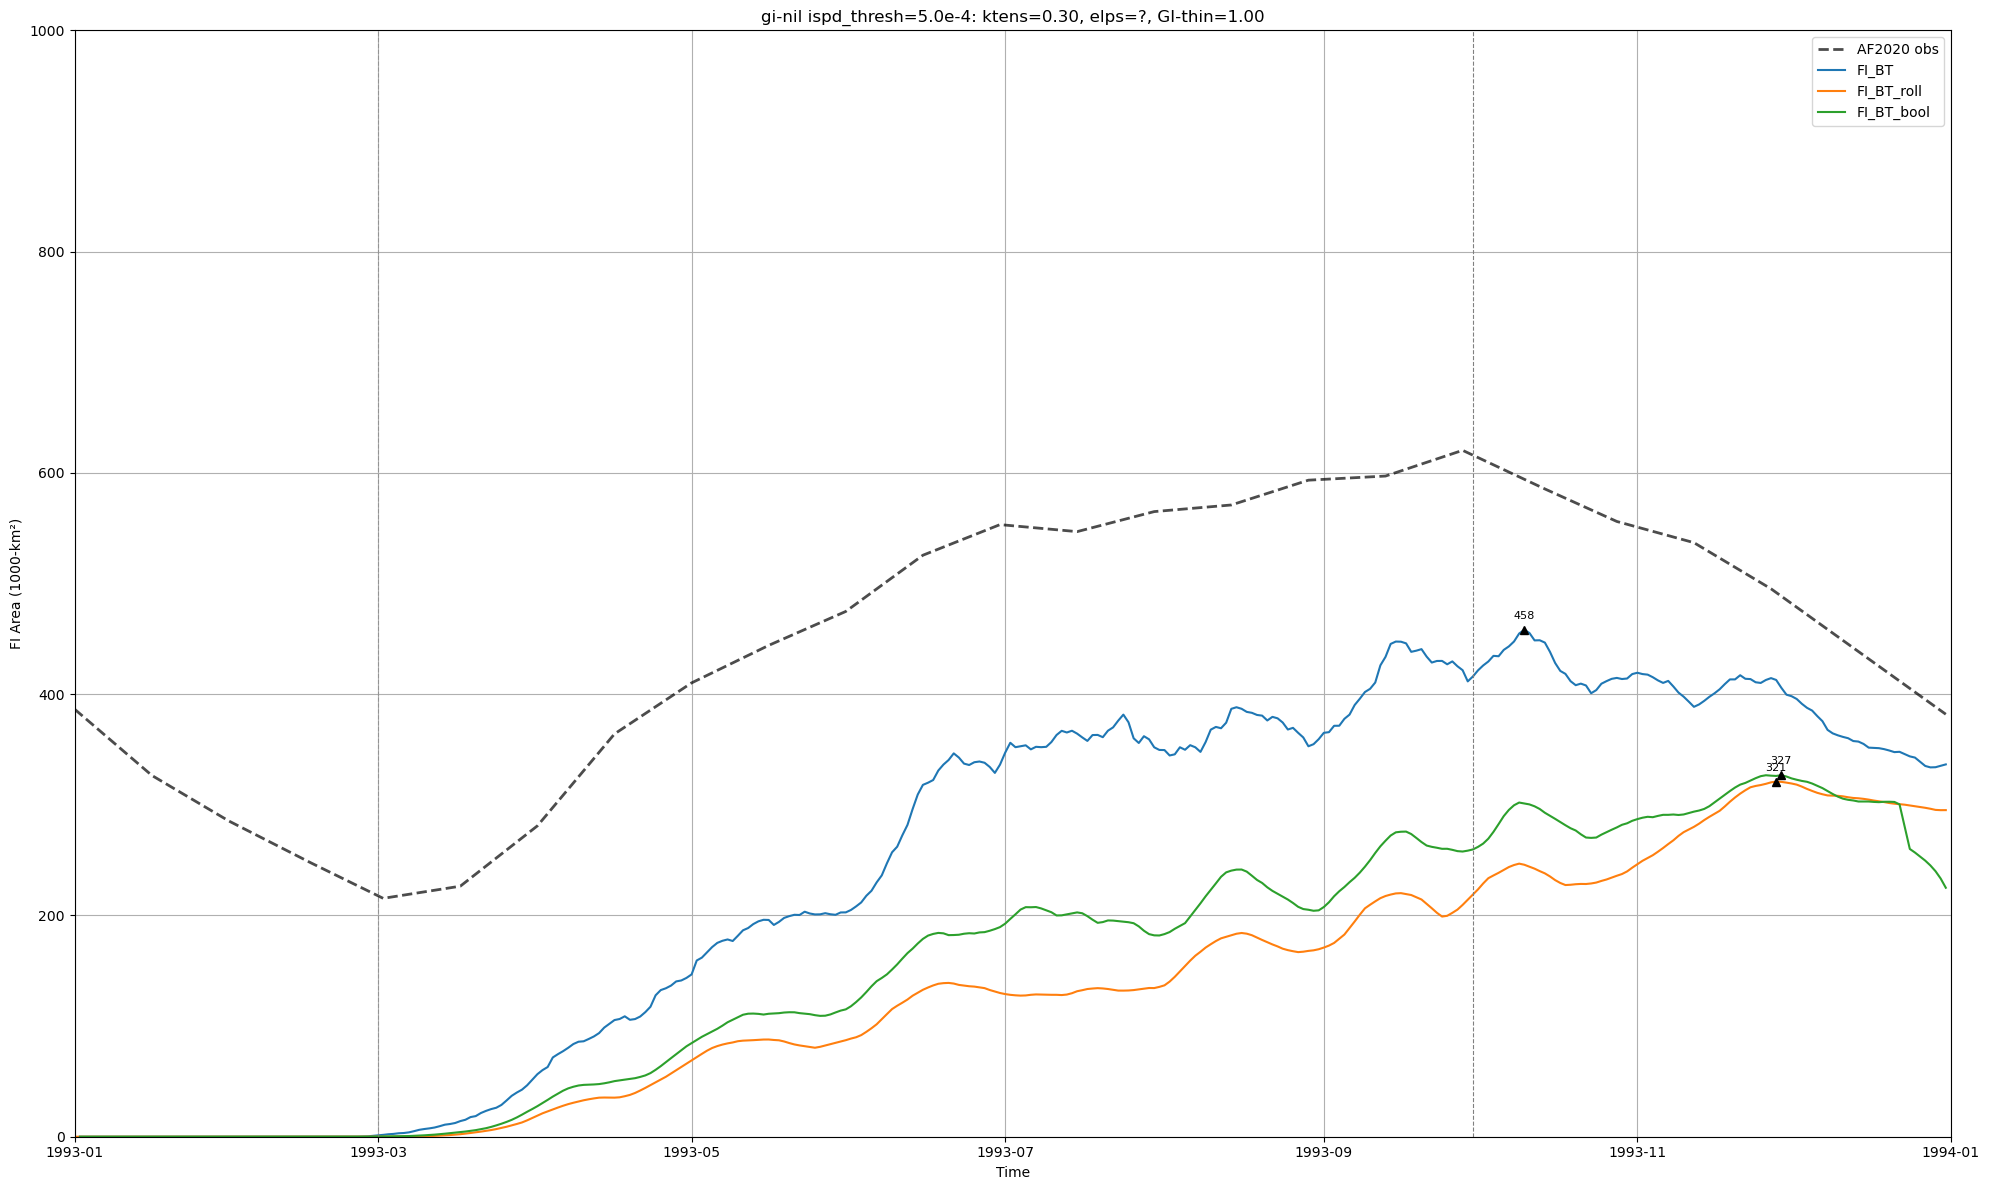

In [71]:
for itype in ice_types:
    SI_proc.sea_ice_metrics_wrapper(ice_type       = itype,
                                    overwrite_zarr = True,
                                    overwrite_png  = True)